# Assignment 8
Rob Lisy

Multi-layer neural network classifier. 
- Goal of building a red or white wine classifier. 

- Perform the appropriate data splits and standardization.
- Use the provided Simple Perceptron Neural Network notebook to develop a multi-layer feed-forward/backpropagation neural network

Be able to adjust the following between experiments:
- Learning Rate
- Number of epochs
- Depth of architecture—number of hidden layers between the input and output layers
- Number of nodes in a hidden layer—width of the hidden layers

Determine a good neural network structure and hyperparameter settings results in the best predictive capability. AS A NOTE: be sure to have the correct loss function. If you are using TF, it's called "binary_crossentropy".

Describe your findings. Assume the goal is to put a drop of wine on a chemical test to read off the features. Then it's automatically sorted based on your model predictions.

- Is this a good model?
- Is this a good model for both red and white classes? Which is it worse for?
if people drink red in the cool months and white in the warm months, will there be any seasonal variations in the accuracy? If your model is equally accurate, it's fine to say no.
Be sure to use COMPLETE sentences and label all graphs/charts.

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Neural Networks
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Logistic Regression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

tf.keras.backend.set_floatx('float64')

file = 'https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/RedWhiteWine.csv'
df = pd.read_csv(file)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Class
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [3]:
df['Class'] = pd.Categorical(df['Class'])
X = df.drop(['Class'], axis=1)
y = df['Class']
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

In [4]:
x_train.shape

(4352, 12)

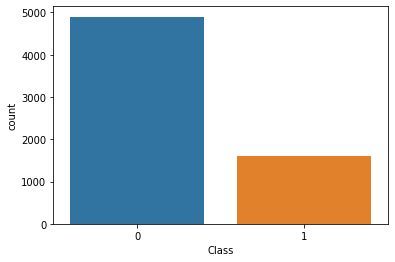

In [5]:
# Plot the classes
# N.B. - Red=1, white wine=0
sns.countplot(x='Class', data=df);

# Benchmark Model

Let's use a simple logistic regression model as our baseline. This gives us the ability to compare any fancy neural networks against something much simpler.

In [6]:
# Train on sample.
lr = LogisticRegressionCV(max_iter = 5000)
lr.fit(x_train, y_train)

# Predict on full sets.
y_hat_train = lr.predict(x_train)
y_hat_test = lr.predict(x_test)

In [7]:
def plot_cf(y_pred, y_actual):
    """ Helper function to make a nice looking confusion matrix.
    """
    cf_matrix=confusion_matrix(y_pred, y_actual)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = [f"{value:0.0f}" for value in cf_matrix.flatten()]
    group_percentages = [f"{value:.2%}" for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');

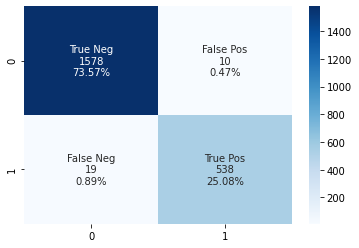

In [8]:
plot_cf(y_test, y_hat_test)

# Neural network

Let's make a neural network and have it do the same thing the logistic regression does.

In [27]:
# using tensorflow from slices
target = df.pop('Class')
dataset = tf.data.Dataset.from_tensor_slices((df.values, target.values))

In [33]:
# Make sure we have the arrays correctly setup.
for feat, targ in dataset.take(5):
  print (f'Features: {feat}, Target: {targ}')

Features: [ 7.4     0.7     0.      1.9     0.076  11.     34.      0.9978  3.51
  0.56    9.4     5.    ], Target: 1
Features: [ 7.8     0.88    0.      2.6     0.098  25.     67.      0.9968  3.2
  0.68    9.8     5.    ], Target: 1
Features: [7.80e+00 7.60e-01 4.00e-02 2.30e+00 9.20e-02 1.50e+01 5.40e+01 9.97e-01
 3.26e+00 6.50e-01 9.80e+00 5.00e+00], Target: 1
Features: [11.2    0.28   0.56   1.9    0.075 17.    60.     0.998  3.16   0.58
  9.8    6.   ], Target: 1
Features: [ 7.4     0.7     0.      1.9     0.076  11.     34.      0.9978  3.51
  0.56    9.4     5.    ], Target: 1


In [34]:
def get_compiled_model(l1, l2, l3, output):
    """
    Function to build a simple model...
    """
    model = tf.keras.Sequential([
       tf.keras.layers.Dense(l1, activation='relu'),
       tf.keras.layers.Dense(l2, activation='relu'),
       tf.keras.layers.Dense(l3, activation='relu'),
       tf.keras.layers.Dense(output)
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [37]:
train_dataset = dataset.shuffle(len(df)).batch(1)

In [39]:
# Layer sizes
l1 = 512
l2 = 256
l3 = 128

# Output size
final_count=1

model = get_compiled_model(l1, l2, l3, final_count)
model.fit(train_dataset, epochs=15)

Epoch 1/15
6497/6497 [==============================] - 6s 864us/step - loss: 0.2481 - accuracy: 0.9204
Epoch 2/15
6497/6497 [==============================] - 6s 888us/step - loss: 0.1631 - accuracy: 0.9435
Epoch 3/15
6497/6497 [==============================] - 5s 836us/step - loss: 0.1293 - accuracy: 0.9507
Epoch 4/15
6497/6497 [==============================] - 5s 840us/step - loss: 0.1169 - accuracy: 0.9598
Epoch 5/15
6497/6497 [==============================] - 6s 869us/step - loss: 0.1072 - accuracy: 0.9624
Epoch 6/15
6497/6497 [==============================] - 6s 881us/step - loss: 0.1011 - accuracy: 0.9649
Epoch 7/15
6497/6497 [==============================] - 6s 884us/step - loss: 0.0923 - accuracy: 0.9724
Epoch 8/15
6497/6497 [==============================] - 6s 907us/step - loss: 0.0975 - accuracy: 0.9689
Epoch 9/15
6497/6497 [==============================] - 6s 899us/step - loss: 0.0884 - accuracy: 0.9729
Epoch 10/15
6497/6497 [==============================] - 6s 966u

# THIS STEP BREAKS....

no idea why...

In [40]:
y_test_pred = model.fit(x_test)

ValueError: in user code:

    /Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:757 train_step
        self.trainable_variables)
    /Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2737 _minimize
        trainable_variables))
    /Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:562 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    /Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:1271 _filter_grads
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['dense_20/kernel:0', 'dense_20/bias:0', 'dense_21/kernel:0', 'dense_21/bias:0', 'dense_22/kernel:0', 'dense_22/bias:0', 'dense_23/kernel:0', 'dense_23/bias:0'].


In [ ]:
# Hyper parameters
epochs = 1000
batch_size = 512
learning_rate = 0.0025

# Layer sizes
l1 = 512
l2 = 256
l3 = 128
# output size
final_count = 2

# Initialize the constructor 
model = tf.keras.Sequential() 
  
# Add layers
model.add(Dense(l1, activation ='relu')) 
model.add(Dense(l2, activation ='relu')) 
model.add(Dense(l3, activation ='sigmoid')) 
model.add(Dense(final_count, activation='sigmoid'))
   
model.compile(loss ='binary_crossentropy',  
  optimizer ='adam', metrics =['accuracy'])

# Training Model 
model.fit(train_attrib, train_labels, epochs = epochs, 
          batch_size = batch_size, verbose = 0) 

In [ ]:
# Plot the model performace over the epochs...
sns.lineplot(x=range(0, len(list(model_logs.history.values())[0])),
             y=list(model_logs.history.values())[0]);

In [ ]:
y_test_hat = model.predict(x_test)

In [ ]:
y_test_hat

In [ ]:
plot_cf(y_test, y_test_hat)